In [1]:
import json
import os
from typing import Callable
from typing import Sequence

import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mpl.rcParams['font.family'] = 'Fira Sans Condensed'


In [2]:
COLORS = {
    'de': '#a52040',
    'el': '#404080',
    'stern_yellow': '#c3c31d',
    'stern_blue': '#0b3f7e',
    'stern_purple': '#7c7cf8',
    'stern_darkbrown': '#370306',
    'darkgreen': '#006400',
    'orange': '#f4a460',
    'green': '#90ee90',
    'blue': '#add8e6',
    'purple': '#800080',
    'err': '#b4b446',
    'Gold': "#FFD700",
    'Light Green': "#90EE90",
    'Light Salmon': "#FFA07A",
    'Pale Turquoise': "#AFEEEE",
    'Light Coral': "#F08080",
    'Light Blue': "#ADD8E6",
    'Light Pink': "#FFB6C1",
    'Moccasin': "#FFE4B5",
    'Powder Blue': "#B0E0E6",
    'Light Grey': "#D3D3D3",
    'Lavender': "#E6E6FA",
    'Navajo White': "#FFDEAD",
    'Wheat': "#F5DEB3",
    'Lemon Chiffon': "#FFFACD",
    'Dark Khaki': "#BDB76B",
    'Light Slate Blue': "#8787df",
    'Light Cyan': "#E0FFFF",
}

MORPH_LOC = {
    'POS': 'Μέρη του λόγου',
    'Case': 'Πτώσεις',
    'Gender': 'Γένος',
    'Number': 'Αριθμός',
    'Person': 'Πρόσωπο',
    'Tense': 'Χρόνος',
    'VerbForm': 'Μορφή ρήματος',
    'Mood': 'Ρήμα',
    'Voice': 'Φωνή',
    'Definite': 'Οριστικότητα',
    'Degree': 'Βαθμίδα',
    'Poss': 'Κτητικότητα',
    'NumType': 'Τύπος αριθμού',
    'PronType': 'Τύπος αντωνυμίας',
    'AdpType': 'Τύπος προθέσης',
    'AdvType': 'Τύπος επιρρήματος',
    'VerbType': 'Τύπος ρήματος',
    'Aspect': 'Ποιόν',
    'Subcat': 'Υποκατηγορία',
    'Foreign': 'Ξενική λέξη',
    'Typo': 'Ορθογραφικό λάθος',
    'SpaceAfter': 'Κενό μετά',
    'PunctType': 'Τύπος στίξης',
    'PunctSide': 'Πλευρά στίξης',
    'Hyph': 'Παύλα',
    'NumForm': 'Μορφή αριθμού',
    # Parts of speech
    'ADJ': 'Επίθετο',
    'ADP': 'Πρόθεση',
    'ADV': 'Επίρρημα',
    'AUX': 'Βοηθητικό ρήμα',
    'CONJ': 'Σύνδεσμος',
    'CCONJ': 'Σύνδεσμος',
    'SCONJ': 'Σύνδεσμος',
    'DET': 'Άρθρο',
    'INTJ': 'Επιφώνημα',
    'NOUN': 'Ουσιαστικό',
    'NUM': 'Αριθμητικό',
    'PART': 'Μόριο',
    'PRON': 'Αντωνυμία',
    'PROPN': 'Ονοματικό',
    'PUNCT': 'Στίξη',
    'SYM': 'Σύμβολο',
    'VERB': 'Ρήμα',
    'X': 'Άγνωστο',
    'SPACE': 'Κενό',
    'PUNCT': 'Στίξη',
    # Morphological features
    'Nom': 'Ονομαστική',
    'Gen': 'Γενική',
    'Dat': 'Δοτική',
    'Acc': 'Αιτιατική',
    'Voc': 'Κλητική',
    'Def': 'Οριστικό',
    'Ind': 'Αόριστο',
    'Masc': 'Αρσενικό',
    'Fem': 'Θηλυκό',
    'Neut': 'Ουδέτερο',
    'Sing': 'Ενικός',
    'Plur': 'Πληθυντικός',
    'Art': 'Άρθρο',
    'Dem': 'Δεικτικό',
    'Emp': 'Εμφατικό',
    'Int': 'Ερωτηματικό',
    'Neg': 'Αρνητικό',
    'Prs': 'Προσωπικό',
    'Rel': 'Αναφορικό',
    'Fin': 'Κλιτός τύπος',
    'Ger': 'Γερούνδιο',
    'Inf': 'Απαρέμφατο',
    'Part': 'Μετοχή',
    'Act': 'Ενεργητική',
    'Pass': 'Παθητική',
    'Cmp': 'Συγκριτκός',
    'Pos': 'Θετικός',
    'Sup': 'Υπερθετικός',
    'Past': 'Παρελθοντικός',
    'Pres': 'Ενεστωτικός',
    'Perf': 'Συντελεσμένος',
    'Card': 'Απόλυτο',
    'Mult': 'Πολλαπλασιαστικά',
    'Ord': 'Τακτικό',
}

# http://universaldependencies.org/u/pos/
# extracted from https://github.com/explosion/spaCy/blob/57a230c6e4844d368d4d12b09993877fc9e50946/spacy/glossary.py#L23
UPOS_TAGS = {
    'ADJ': 'adjective',
    'ADP': 'adposition',
    'ADV': 'adverb',
    'AUX': 'auxiliary',
    'CONJ': 'conjunction',
    'CCONJ': 'coordinating conjunction',
    'DET': 'determiner',
    'INTJ': 'interjection',
    'NOUN': 'noun',
    'NUM': 'numeral',
    'PART': 'particle',
    'PRON': 'pronoun',
    'PROPN': 'proper noun',
    'PUNCT': 'punctuation',
    'SCONJ': 'subordinating conjunction',
    'SYM': 'symbol',
    'VERB': 'verb',
    'X': 'other',
    'EOL': 'end of line',
    'SPACE': 'space',
}

# UPOS_COLORS = dict(zip(UPOS_TAGS.keys(), COLORS.values()))

UPOS_COLORS_light = {
    'ADJ': '#FFB74D',       # Light Orange
    'ADP': '#FFCC80',       # Light Amber
    'ADV': '#CE93D8',       # Light Purple
    'AUX': '#F06292',       # Light Pink
    'CONJ': '#9FA8DA',      # Light Indigo
    'CCONJ': '#9FA8DA',     # Light Indigo
    'DET': '#80DEEA',       # Light Cyan
    'INTJ': '#F06292',      # Light Pink
    'NOUN': '#FFD54F',      # Light Yellow
    'NUM': '#C5E1A5',       # Light Green
    'PART': '#A5D6A7',      # Light Greenish
    'PRON': '#A5D6A7',      # Light Greenish
    'PROPN': '#B39DDB',     # Light Purple
    'PUNCT': '#BCAAA4',     # Light Brown
    'SCONJ': '#9FA8DA',     # Light Indigo
    'SYM': '#BCAAA4',       # Light Brown
    'VERB': '#FFB74D',      # Light Orange
    'X': '#E0E0E0',         # Light Gray
    'EOL': '#E0E0E0',       # Light Gray
    'SPACE': '#E0E0E0',     # Light Gray
}

UPOS_COLORS = {
    # 'ADJ': '#FF5722',       # Deep Orange
    # 'ADP': '#FF9800',       # Orange
    # 'ADV': '#9C27B0',       # Purple
    # 'AUX': '#E91E63',       # Pink
    # 'CONJ': '#3F51B5',      # Indigo
    # 'CCONJ': '#3F51B5',     # Indigo
    # 'DET': '#00BCD4',       # Cyan
    # 'INTJ': '#E91E63',      # Pink
    # 'NOUN': '#FFC107',      # Amber
    # 'NUM': '#8BC34A',       # Light Green
    # 'PART': '#4CAF50',      # Green
    # 'PRON': '#4CAF50',      # Green
    # 'PROPN': '#673AB7',     # Deep Purple
    # 'PUNCT': '#795548',     # Brown
    # 'SCONJ': '#3F51B5',     # Indigo
    # 'SYM': '#795548',       # Brown
    # 'VERB': '#FF5722',      # Deep Orange
    # 'X': '#424242',         # Dark Gray
    # 'EOL': '#424242',       # Dark Gray
    # 'SPACE': '#424242',     # Dark Gray
    'SCONJ': '#FF7F50',     # Coral
    'CCONJ': '#FF7F50',     # Coral
    'VERB': '#8A2BE2',      # Blue Violet
    'ADV': '#32CD32',       # Lime Green
    'NUM': '#FF69B4',       # Hot Pink
    'PRON': '#FF4500',      # Orange Red
    'DET': '#1E90FF',       # Dodger Blue
    'PUNCT': '#808080',     # Gray
    'ADP': '#FF8C00',       # Dark Orange
    'ADJ': '#00CED1',       # Dark Turquoise
    'PART': '#FF1493',      # Deep Pink
    'PROPN': '#9932CC',     # Dark Orchid
    'AUX': '#4B0082',       # Indigo
    'NOUN': '#800000',      # Maroon
    'INTJ': '#00FFFF',      # Cyan
    'SYM': '#FF00FF',       # Magenta
    'X': '#808080',         # Dark Gray
    'EOL': '#808080',       # Dark Gray
    'SPACE': '#808080',     # Dark Gray
}


TAG_ENT_TEMPLATE = """
<mark style="color: #fff; background: {bg}; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em; font-family: Arial;">
    {text}
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 1ch">{label}{kb_link}</span>
</mark>
"""


def vcu(df_grouped, col, *args):
    """Returns the value counts unstacked of a column of a grouped DataFrame."""
    return df_grouped[col].value_counts().unstack()


def meets_plot_criteria(
        df: pd.DataFrame,
        col: str,
        *,
        grouped: pd.DataFrame,
        func: Callable,
        func_args: Sequence = None,
) -> bool:
    return (
        col[0].isupper()
        # do not plot columns with only one value
        and len(df[col].value_counts()) > 1
        # do not plot columns with only one language
        # and len(grouped[col].value_counts()) > 1
        # do not plot columns with values only in one language
        # and len(func(grouped, col, func_args)) > 1
    )


def convert_to_lang_tick(lang: str, level: int = 1) -> str:
    """Returns the language ticks for the plots."""
    level = level - 1
    lang = lang.removeprefix('(').removesuffix(')').replace("'", '')
    # lang = lang.upper()
    return lang.split(',')[level].strip()


def save_fig(
    fig: plt.Figure,
    name: str,
    path: str = './graphs',
        format: str = 'svg',
        **kwargs) -> None:
    """Saves a matplotlib figure to a file in `./graphs`
    if `path` not specified."""
    if path is None:
        path = os.getcwd()
    else:
        path = os.path.join('graphs', path)
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(
        os.path.join(path, f'{name}.{format}'),
        format=format,
        bbox_inches='tight',
        **kwargs
    )


In [3]:
analysis_df = pd.read_csv('translations_analysis.csv', encoding='utf-8')
analysis_df.sample(5)


,id,version,translator,sentence,preprocessed_text,detected_lang,num_tokens,token_freqs,lemma_freqs,token_lemma_diff,pos_tags,pos_freqs,morph_features,syntax_deps,named_entities,lemmas,word_vectors,avg_vector
19,4,Ομοιολειτουργική,ChatGPT (Ομ.),Mit dem Tod einer Person geht ihr gesamtes Ver...,Mit dem Tod einer Person geht ihr gesamtes Ver...,DE,24,"{'mit': 1, 'dem': 2, 'tod': 1, 'einer': 1, 'pe...","{'mit': 1, 'der': 2, 'Tod': 1, 'ein': 2, 'Pers...",2,"['ADP', 'DET', 'NOUN', 'DET', 'NOUN', 'VERB', ...","{'VERB': 1, 'NOUN': 8, 'ADP': 5, 'DET': 7, 'CC...","[{""dem"": {""POS"": ""DET"", ""Case"": ""Dat"", ""Defini...","['mo', 'nk', 'nk', 'nk', 'ag', 'ROOT', 'nk', '...",[],"['mit', 'der', 'Tod', 'ein', 'Person', 'gehen'...","[array([-1.4211e+00, -2.5641e+00, -4.3950e+00,...",[ 1.480937 -0.4378775 -1.1799382 1.744269...
8,2,Τεκμηριωτική,ChatGPT (Τεκ.),Die interpretativen Bestimmungen der Artikel 2...,Die interpretativen Bestimmungen der Artikel 0...,DE,18,"{'die': 2, 'interpretativen': 1, 'bestimmungen...","{'der': 3, 'interpretativ': 1, 'Bestimmung': 1...",1,"['DET', 'ADJ', 'NOUN', 'DET', 'NOUN', 'NUM', '...","{'VERB': 1, 'NOUN': 6, 'ADP': 2, 'DET': 3, 'NU...","[{""Die"": {""POS"": ""DET"", ""Case"": ""Nom"", ""Defini...","['nk', 'nk', 'sb', 'nk', 'ag', 'nk', 'cd', 'cj...",[],"['der', 'interpretativ', 'Bestimmung', 'der', ...","[array([ -5.4694 , 4.5784 , 1.3819 , ...",[ 1.25269389e+00 7.26877213e-01 2.68144399e-...
5,2,ελλΑΚ-1951,Γώγος,"Für die Fristen, welche durch Gesetz, gerichtl...",Für die Fristen welche durch Gesetz gerichtlic...,DE,20,"{'für': 1, 'die': 2, 'fristen': 1, 'welche': 1...","{'für': 1, 'der': 3, 'Frist': 1, 'welcher': 1,...",1,"['ADP', 'DET', 'NOUN', 'DET', 'ADP', 'NOUN', '...","{'VERB': 2, 'NOUN': 6, 'ADP': 2, 'DET': 4, 'NU...","[{""die"": {""POS"": ""DET"", ""Case"": ""Nom"", ""Defini...","['mo', 'nk', 'nk', 'nk', 'mo', 'nk', 'nk', 'oa...","[('Auslegungsvorschriften', 'ORG')]","['für', 'der', 'Frist', 'welcher', 'durch', 'G...","[array([ -1.361 , -3.7974 , 2.3915 , 1...",[ 1.9982008e+00 1.3078466e-01 4.3170714e-01 ...
20,5,ελλΑΚ-1951,Γώγος,"Erbe kann nur derjenige sein, der zur Zeit des...",Erbe kann nur derjenige sein der zur Zeit des ...,DE,17,"{'erbe': 1, 'kann': 1, 'nur': 1, 'derjenige': ...","{'Erbe': 1, 'können': 1, 'nur': 1, 'derjenige'...",2,"['NOUN', 'AUX', 'ADV', 'PRON', 'AUX', 'DET', '...","{'VERB': 2, 'NOUN': 4, 'ADP': 1, 'DET': 3, 'PR...","[{""Erbe"": {""POS"": ""NOUN"", ""Case"": ""Nom"", ""Gend...","['sb', 'ROOT', 'mo', 'sb', 'oc', 'sb', 'mo', '...",[],"['Erbe', 'können', 'nur', 'derjenige', 'sein',...","[array([-2.6245e+00, -9.5688e-01, 1.7899e+00,...",[ 1.81538737e+00 4.32683617e-01 -1.13713408e+...
21,5,ελλΑΚ-1940,DeepL,"Ein Erbe kann nur dann Erbe werden, wenn er zu...",Ein Erbe kann nur dann Erbe werden wenn er zum...,DE,19,"{'ein': 1, 'erbe': 2, 'kann': 1, 'nur': 1, 'da...","{'ein': 1, 'Erbe': 2, 'können': 1, 'nur': 1, '...",0,"['DET', 'NOUN', 'AUX', 'ADV', 'ADV', 'NOUN', '...","{'VERB': 1, 'NOUN': 4, 'ADP': 1, 'DET': 2, 'PR...","[{""Ein"": {""POS"": ""DET"", ""Case"": ""Nom"", ""Defini...","['nk', 'sb', 'ROOT', 'mo', 'mo', 'pd', 'oc', '...",[],"['ein', 'Erbe', 'können', 'nur', 'dann', 'Erbe...","[array([ 3.6436e+00, 6.2160e-01, -4.3275e+00,...",[ 1.85216057e+00 -4.69577551e-01 -5.77074945e-...


In [4]:
morph_df = analysis_df[['id', 'version', 'translator', 'morph_features']]
morph_df['morph_features'] = morph_df['morph_features'].apply(json.loads)
morph_df = morph_df.explode('morph_features')
morph_df['morph_features'] = morph_df['morph_features'].apply(
    json.dumps, ensure_ascii=False)
# Unpack the nested dictionary into separate columns
# morph_df = morph_df.join(pd.json_normalize(morph_df['morph_features']))
morph_df['morph_features'] = morph_df['morph_features'].apply(
    json.loads).apply(lambda x: x.values())
morph_df = morph_df.explode('morph_features')
morph_df_ = morph_df['morph_features'].apply(pd.Series)

# for i, val in enumerate(morph_df['morph_features'].items()):
#     for _, v in morph_df['morph_features'].items():
#         # print(i+1,v)
#         try:
#             morph_df.at[i, 'morph_features'] = v
#             for morph, j in v.items():
#                 # print(morph, j)
#                 # at given the index i and the morphological feature morph, set the value j to the corresponding cell
#                 morph_df.at[i, morph] = j
#         except AttributeError:
#             continue

# morph_df = pd.concat([morph_df, pd.DataFrame({k1: v1})], axis=1)
# morph_df['morph_features'] = morph_df['morph_features'].apply(lambda x: [d.values() for d in x])
# morph_df = morph_df.explode('morph_features')
# morph_df['morph_features'] = morph_df['morph_features'].apply(list)
# take the first element of each list and create a new column
# morph_df['pos_tag'] = morph_df['morph_features'].apply(lambda x: x[0])
# morph_df['morph_features'] = morph_df['morph_features'].apply(lambda x: x[1:])
# convert the values of pos_tag column to separate columns
# morph_df = morph_df.explode('morph_features')
# morph_df = morph_df.join(pd.DataFrame(morph_df.pop('pos_tag').tolist(), index=morph_df.index))

# convert the values of morph_features column to separate columns assigned to pos_tag
# morph_df_ = morph_df.pop('morph_features').apply(pd.Series).fillna('')
# morph_df_ = morph_df_.join(morph_df['pos_tag'])
morph_df_ = pd.concat([morph_df, morph_df_], axis=1)
# morph_df_ = morph_df_.join(morph_df['pos_tag'])

# morph_df_ = morph_df_.apply(lambda x: pd.Series(x)).fillna('')
# explode the morph_features column into separate rows
# morph_df_ = pd.concat([morph_df, morph_df_], axis=1)
with pd.option_context('display.max_colwidth', None):
    display(morph_df_.drop(columns=['morph_features']))


C:\Users\dimboump\AppData\Local\Temp\ipykernel_225052\1986633810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morph_df['morph_features'] = morph_df['morph_features'].apply(json.loads)


,id,version,translator,POS,Case,Definite,Gender,Number,PronType,Mood,Person,Tense,VerbForm,Degree,Reflex,Poss
0,1,ελλΑΚ-1951,Γώγος,DET,Nom,Def,Masc,Sing,Art,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,ελλΑΚ-1951,Γώγος,NOUN,Dat,NaN,Fem,Sing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,ελλΑΚ-1951,Γώγος,DET,Gen,Ind,Fem,Sing,Art,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,ελλΑΚ-1951,Γώγος,NOUN,Gen,NaN,Fem,Sing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,ελλΑΚ-1951,Γώγος,AUX,NaN,NaN,NaN,Sing,NaN,Ind,3,Pres,Fin,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,5,Ομοιολειτουργική,ChatGPT (Ομ.),NOUN,Dat,NaN,Masc,Sing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,5,Ομοιολειτουργική,ChatGPT (Ομ.),NOUN,Gen,NaN,Fem,Sing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,5,Ομοιολειτουργική,ChatGPT (Ομ.),VERB,NaN,NaN,NaN,Sing,NaN,Ind,3,Pres,Fin,NaN,NaN,NaN
24,5,Ομοιολειτουργική,ChatGPT (Ομ.),VERB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Part,NaN,NaN,NaN


Μεταφραστής: ChatGPT (Ομ.)


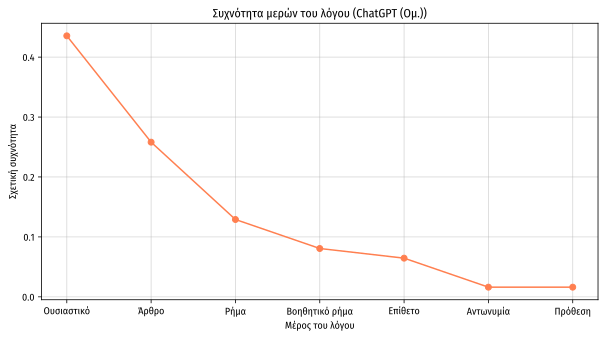

Μεταφραστής: ChatGPT (Τεκ.)


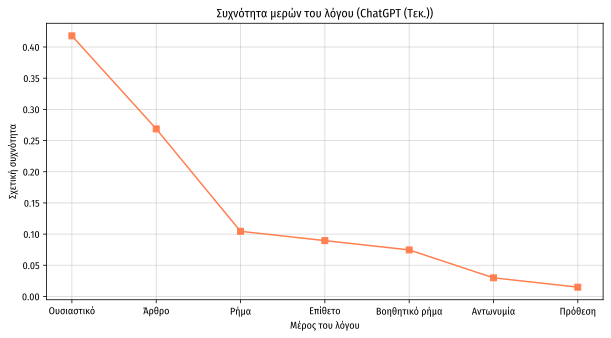

Μεταφραστής: DeepL


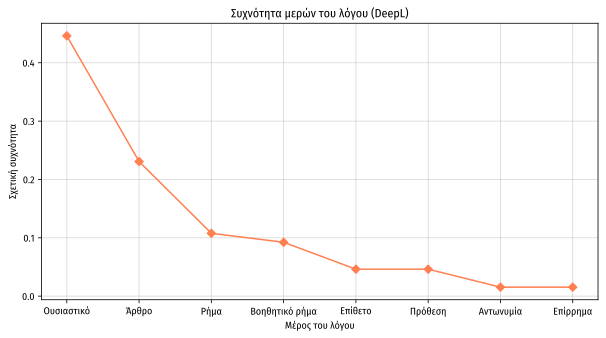

Μεταφραστής: Google


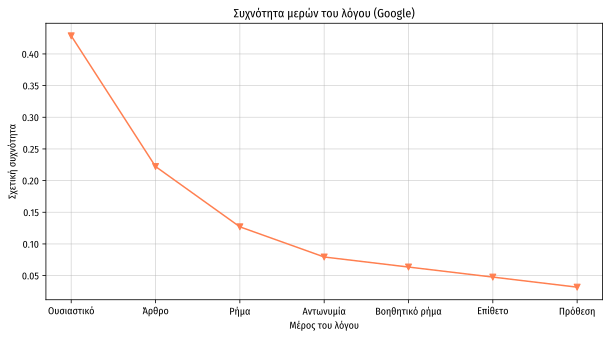

Μεταφραστής: Γώγος


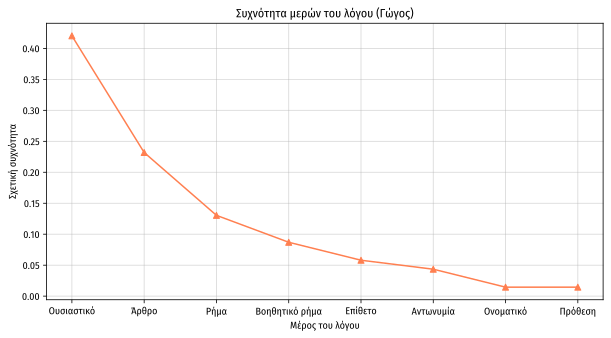

C:\Users\dimboump\AppData\Local\Temp\ipykernel_225052\394839342.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


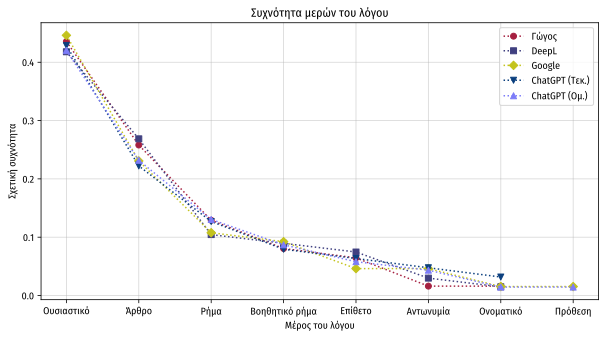

In [23]:
# plot the frequency of each morphological feature per translator
markers = ['o', 's', 'D', 'v', '^', '<', '>', '1', '2', '3', '4',
           '8', 'p', 'P', '*', 'h', 'H', '+', 'x', 'X', 'd', 'D', '|', '_']
clrs = ['#a52040', '#404080', '#c3c31d', '#0b3f7e', '#7c7cf8']

for i, (translator, group) in enumerate(morph_df_.groupby('translator')):
    print('Μεταφραστής:', translator)
    vcs = group['POS'].map(MORPH_LOC.get).value_counts(normalize=True)
    fig, ax = plt.subplots(figsize=(10, 5))
    plot = vcs.plot.line(title=f'Συχνότητα μερών του λόγου ({translator})',
                         xlabel='Μέρος του λόγου', ylabel='Σχετική συχνότητα',
                         rot=0, color=list(UPOS_COLORS.values())[1:], zorder=10, marker=markers[i])
    plot.grid(True, zorder=0, alpha=.5)
    plt.show()

# combine the lines into a single plot
fig, ax = plt.subplots(figsize=(10, 5))
for i, (translator, group) in enumerate(morph_df_.groupby('translator')):
    vcs = group['POS'].map(MORPH_LOC.get).value_counts(normalize=True)
    plot = vcs.plot.line(title=f'Συχνότητα μερών του λόγου', linestyle=':',
                         xlabel='Μέρος του λόγου', ylabel='Σχετική συχνότητα',
                         color=clrs[i], marker=markers[i], rot=0, zorder=10)
    plot.grid(True, zorder=0, alpha=.5)
    save_fig(fig, f"{translator.replace(' –', '_').replace(' Ομ._', '').replace(' Τεκ._', '')}_line_relative",
             path=f'translations/parts_of_speech/all', format='svg')
fig.legend(list(morph_df_['translator'].unique()), bbox_to_anchor=(.9, .88))
fig.show()
